In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.mlab as mlab

In [4]:
# ### Uncomment only one of these to define what data is actually sent to the Discriminator
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
#(name, preprocess, d_input_func) = ("Data and diffs", lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2)
(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)
print("Using data [%s]" % (name))

Using data [Only 4 moments]


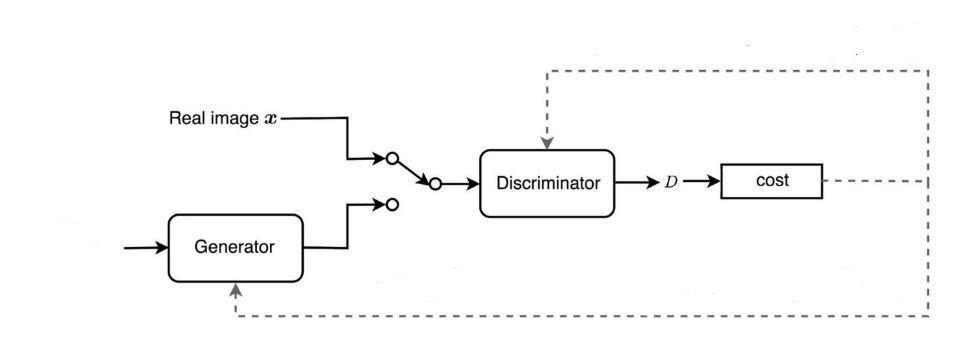

## DATA: Target data and generator input data

Functions to generate R and N

In [ ]:
# Data params
data_mean = 4
data_stddev = 1.25

In [5]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

Define other supporting functions

In [7]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)

## MODELS: Generator model and discriminator model

In [8]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

## Training process

Epoch 0: D (0.7446653842926025 real_err, 0.6288319230079651 fake_err) G (0.7596178650856018 err); Real Dist ([4.092120450258255, 1.324332070013258]),  Fake Dist ([-0.11545683830976486, 0.011621116941009882]) 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


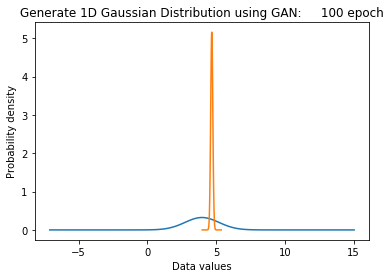

Epoch 100: D (0.6691399812698364 real_err, 0.6459161639213562 fake_err) G (0.7381039261817932 err); Real Dist ([3.934167115211487, 1.2200696039592562]),  Fake Dist ([4.743733807563782, 0.08321041292579218]) 


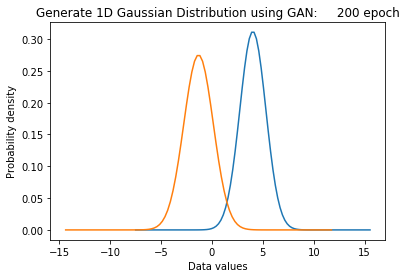

Epoch 200: D (0.49941661953926086 real_err, 0.8043569326400757 fake_err) G (0.5131996870040894 err); Real Dist ([4.083441538125276, 1.2463244909492321]),  Fake Dist ([-1.250708201766014, 1.2763305963138907]) 


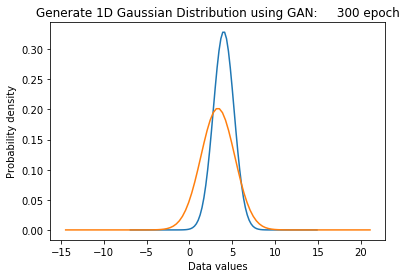

Epoch 300: D (0.6747483611106873 real_err, 0.6735864281654358 fake_err) G (0.7054137587547302 err); Real Dist ([4.039204680562019, 1.2642272349303652]),  Fake Dist ([3.315051510334015, 2.05323258375742]) 


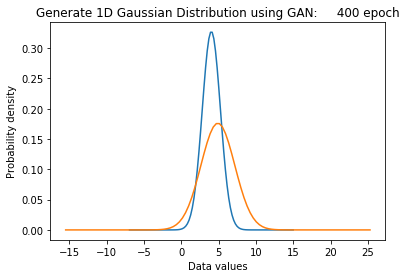

Epoch 400: D (0.4942793846130371 real_err, 0.5599576234817505 fake_err) G (0.8383857011795044 err); Real Dist ([4.001821983382106, 1.299341065707132]),  Fake Dist ([4.462064414978028, 2.63903827201491]) 


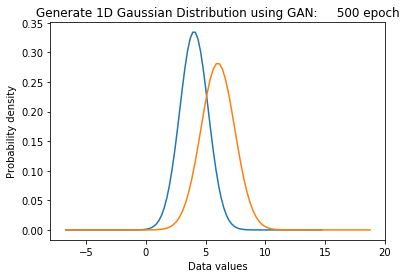

Epoch 500: D (0.6652621030807495 real_err, 0.6686802506446838 fake_err) G (0.7180559635162354 err); Real Dist ([3.9713281299322842, 1.2361507970067505]),  Fake Dist ([6.076068974494934, 1.4307499479119095]) 


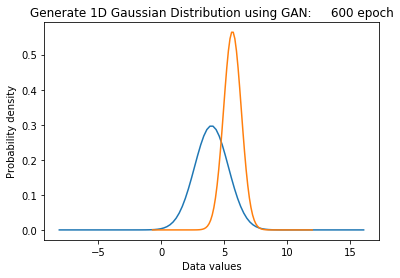

Epoch 600: D (0.8112127780914307 real_err, 0.7110888957977295 fake_err) G (0.6724366545677185 err); Real Dist ([4.0231011449992655, 1.2404500047224287]),  Fake Dist ([5.716752808570861, 0.66265799486051]) 


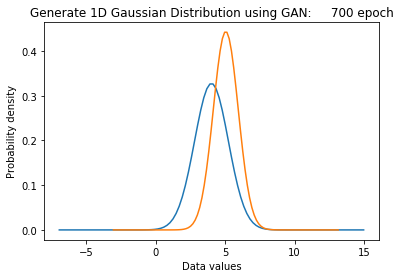

Epoch 700: D (0.6795403957366943 real_err, 0.6600746512413025 fake_err) G (0.7345848679542542 err); Real Dist ([4.02532511973381, 1.2518341779445372]),  Fake Dist ([5.053115871429443, 0.9371114843737217]) 


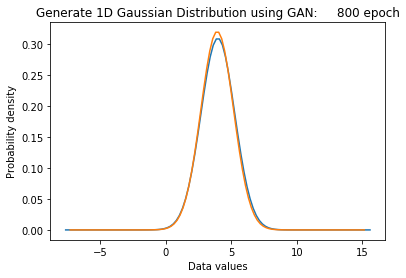

Epoch 800: D (0.6935449838638306 real_err, 0.6983805298805237 fake_err) G (0.6963270306587219 err); Real Dist ([3.9007638666033744, 1.2166229034218794]),  Fake Dist ([3.865889409780502, 1.227554022565299]) 


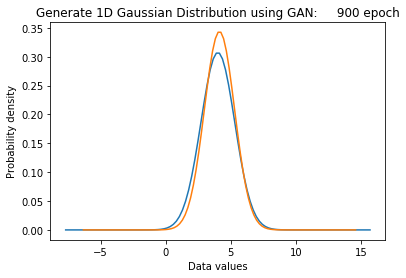

Epoch 900: D (0.6995759606361389 real_err, 0.6904807090759277 fake_err) G (0.6923777461051941 err); Real Dist ([4.0415091051459315, 1.2693409881639064]),  Fake Dist ([3.987449948310852, 1.2412325847125196]) 


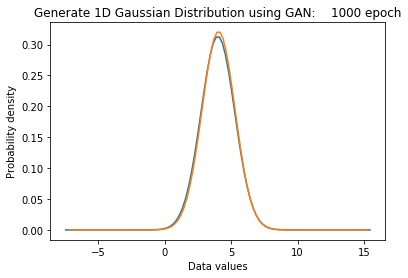

Epoch 1000: D (0.6907482147216797 real_err, 0.6926580667495728 fake_err) G (0.6925013661384583 err); Real Dist ([3.9587655826210977, 1.2439002379413753]),  Fake Dist ([3.926764014720917, 1.2100097967822967]) 


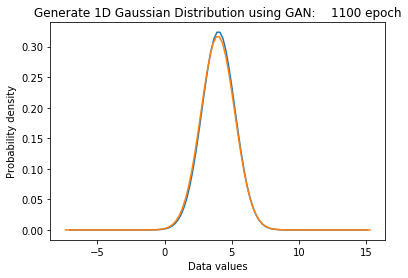

Epoch 1100: D (0.692223846912384 real_err, 0.6941386461257935 fake_err) G (0.6943515539169312 err); Real Dist ([4.043028993308544, 1.2095883256790332]),  Fake Dist ([3.978982671737671, 1.2253134003843864]) 


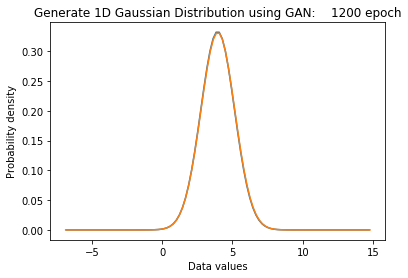

Epoch 1200: D (0.6918981671333313 real_err, 0.6929385662078857 fake_err) G (0.6920214295387268 err); Real Dist ([4.0302581686377525, 1.2989722909750807]),  Fake Dist ([4.0344129309654235, 1.0885916522814443]) 


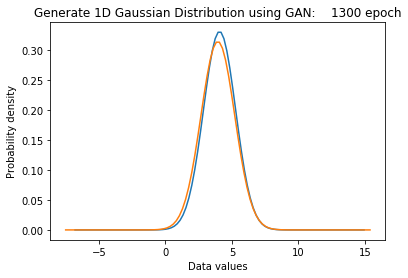

Epoch 1300: D (0.6966416239738464 real_err, 0.692924976348877 fake_err) G (0.6926829814910889 err); Real Dist ([4.086033388495445, 1.2743598198319865]),  Fake Dist ([4.039969869852066, 1.3228521341108406]) 


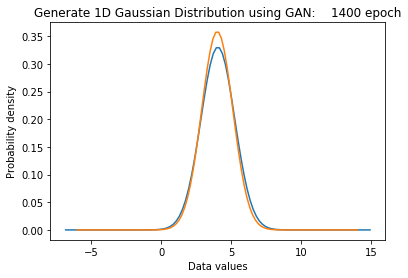

Epoch 1400: D (0.690567135810852 real_err, 0.6955263018608093 fake_err) G (0.6910588145256042 err); Real Dist ([3.9659218255281448, 1.2341779376109596]),  Fake Dist ([3.8704267301559447, 1.1807829491514528]) 


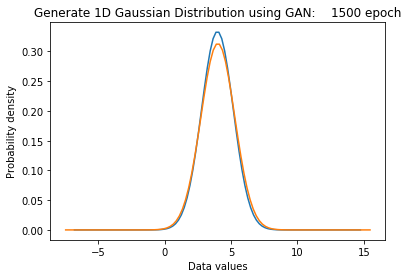

Epoch 1500: D (0.6921588182449341 real_err, 0.6939066052436829 fake_err) G (0.6924388408660889 err); Real Dist ([4.027931993544102, 1.2409883563172432]),  Fake Dist ([3.9566236910820005, 1.2779331314047935]) 


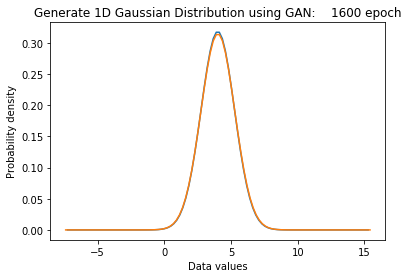

Epoch 1600: D (0.6936348676681519 real_err, 0.6942803263664246 fake_err) G (0.6924786567687988 err); Real Dist ([3.9445625690221786, 1.2171339344228165]),  Fake Dist ([4.023601917266846, 1.2215305339753573]) 


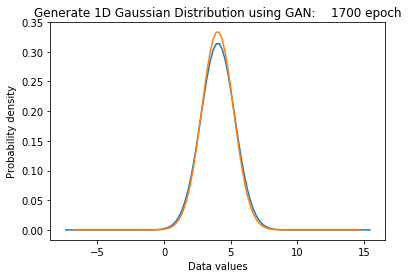

Epoch 1700: D (0.6942639946937561 real_err, 0.6942294836044312 fake_err) G (0.6924063563346863 err); Real Dist ([4.101230081200599, 1.263187369858626]),  Fake Dist ([4.050373235464096, 1.2275442300698562]) 


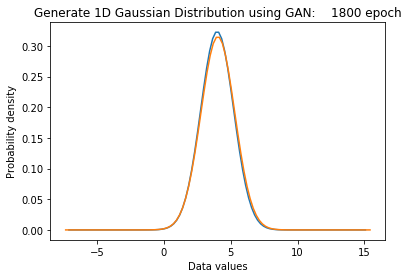

Epoch 1800: D (0.6924527883529663 real_err, 0.6938396692276001 fake_err) G (0.6923786997795105 err); Real Dist ([4.063467200040817, 1.2049735157070407]),  Fake Dist ([3.974719425678253, 1.2551069535177504]) 


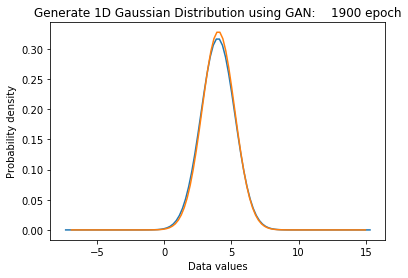

Epoch 1900: D (0.6926716566085815 real_err, 0.6934911608695984 fake_err) G (0.6924399137496948 err); Real Dist ([3.9548133178949354, 1.1923864003782998]),  Fake Dist ([3.9740375835895536, 1.2464822284187023]) 


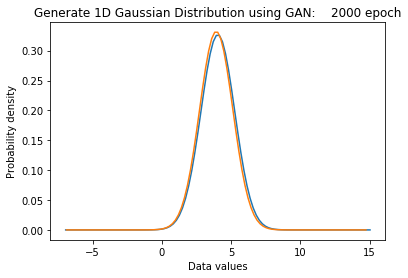

Epoch 2000: D (0.6924821138381958 real_err, 0.6925697922706604 fake_err) G (0.6936129331588745 err); Real Dist ([3.9857287080287933, 1.2288479527654297]),  Fake Dist ([3.9886404705047607, 1.2081441907044477]) 


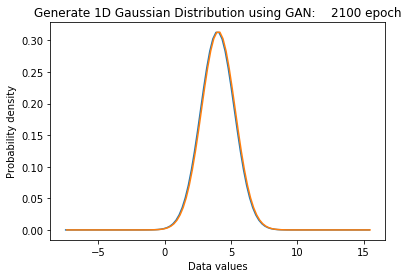

Epoch 2100: D (0.6934174299240112 real_err, 0.6937232613563538 fake_err) G (0.6923548579216003 err); Real Dist ([3.927088136797771, 1.2358140658176322]),  Fake Dist ([4.046525963068008, 1.2602439145073066]) 


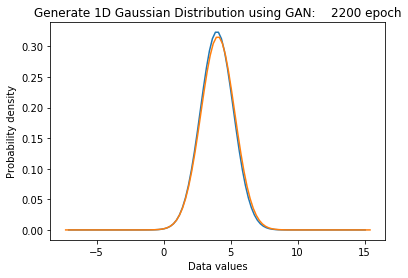

Epoch 2200: D (0.6930040121078491 real_err, 0.6932433843612671 fake_err) G (0.6933112144470215 err); Real Dist ([4.019964573383331, 1.2424148205048136]),  Fake Dist ([3.992094340324402, 1.2629750242281406]) 


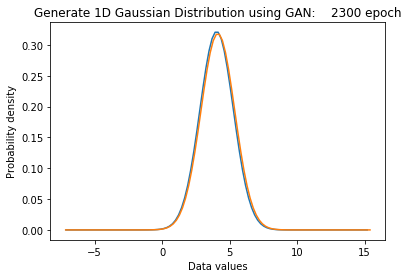

Epoch 2300: D (0.693073034286499 real_err, 0.6933351755142212 fake_err) G (0.6928512454032898 err); Real Dist ([4.034872312039137, 1.2540760200414383]),  Fake Dist ([3.8852381339073183, 1.2259989559451876]) 


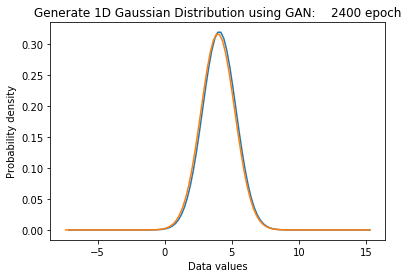

Epoch 2400: D (0.6933857798576355 real_err, 0.6934642195701599 fake_err) G (0.6927089691162109 err); Real Dist ([3.9538011669516564, 1.3165991375525579]),  Fake Dist ([4.006927966117859, 1.1968198548761948]) 


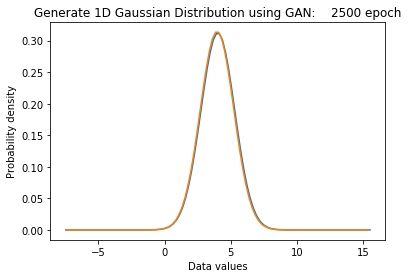

Epoch 2500: D (0.6927867531776428 real_err, 0.6935152411460876 fake_err) G (0.6926451921463013 err); Real Dist ([3.9778873222470286, 1.2759346444877564]),  Fake Dist ([3.932981593132019, 1.2628376802118564]) 


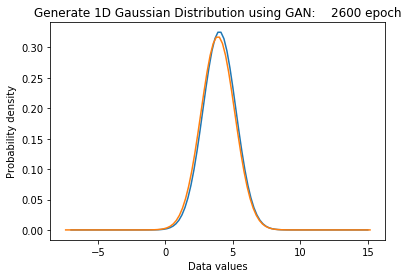

Epoch 2600: D (0.6925002932548523 real_err, 0.6935221552848816 fake_err) G (0.6922426819801331 err); Real Dist ([4.084342808604241, 1.2620413670502957]),  Fake Dist ([4.080852098941803, 1.2093639472120903]) 


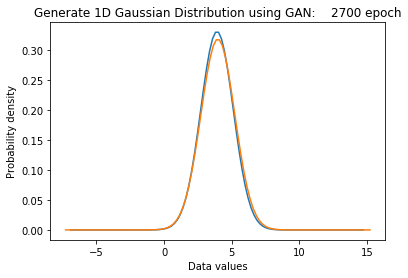

Epoch 2700: D (0.6928579211235046 real_err, 0.6934779286384583 fake_err) G (0.6927610039710999 err); Real Dist ([3.9730614562928674, 1.2866372226624994]),  Fake Dist ([4.000606925964355, 1.2275190873405093]) 


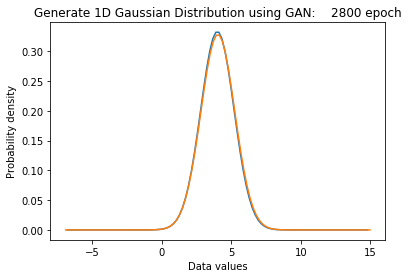

Epoch 2800: D (0.6927154064178467 real_err, 0.693717896938324 fake_err) G (0.6931488513946533 err); Real Dist ([3.8694567184150217, 1.2109202321217771]),  Fake Dist ([4.012276671886444, 1.2628626179514553]) 


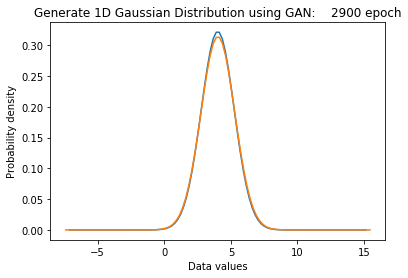

Epoch 2900: D (0.6931920051574707 real_err, 0.6928537487983704 fake_err) G (0.6929848194122314 err); Real Dist ([4.079320185899735, 1.255600556782533]),  Fake Dist ([3.975134268760681, 1.1871780289713219]) 


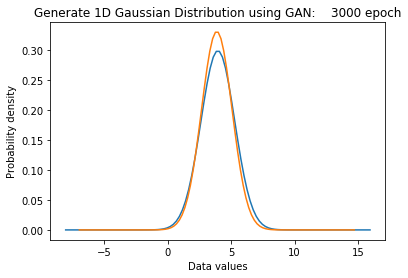

Epoch 3000: D (0.6925484538078308 real_err, 0.6938750743865967 fake_err) G (0.6926831007003784 err); Real Dist ([4.089459333777428, 1.231398382331816]),  Fake Dist ([3.9094208254814147, 1.2295633916180586]) 


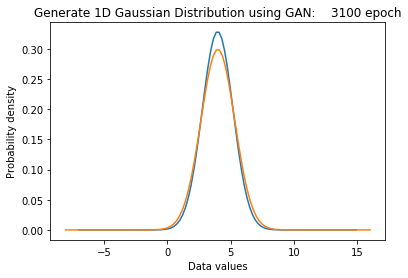

Epoch 3100: D (0.6946195363998413 real_err, 0.6934729218482971 fake_err) G (0.6933180093765259 err); Real Dist ([4.031927335977555, 1.224565304491569]),  Fake Dist ([4.035928692340851, 1.2732013391798005]) 


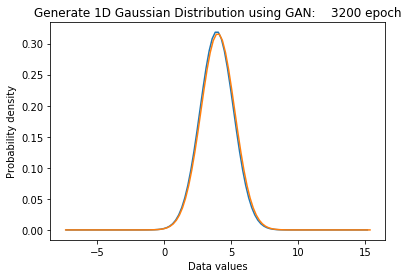

Epoch 3200: D (0.6932766437530518 real_err, 0.6934555172920227 fake_err) G (0.6931060552597046 err); Real Dist ([3.9867802212238312, 1.2309092397625812]),  Fake Dist ([4.06568162894249, 1.3003203515966522]) 


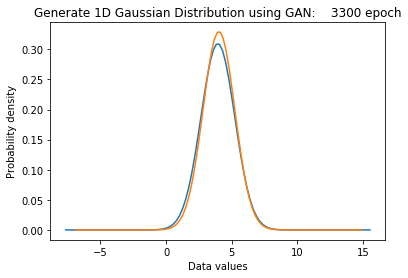

Epoch 3300: D (0.6927697062492371 real_err, 0.6940271854400635 fake_err) G (0.6934515833854675 err); Real Dist ([3.992406297981739, 1.2989385280722507]),  Fake Dist ([3.9503768260478975, 1.2287338822700522]) 


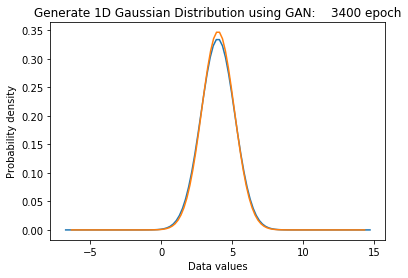

Epoch 3400: D (0.6936751008033752 real_err, 0.6931458711624146 fake_err) G (0.6929936408996582 err); Real Dist ([3.9768388426303862, 1.3053444765312618]),  Fake Dist ([3.950567761182785, 1.1812396192116759]) 


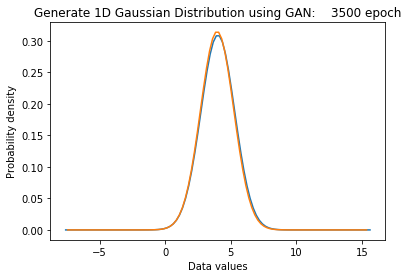

Epoch 3500: D (0.692279577255249 real_err, 0.6915326118469238 fake_err) G (0.6928272843360901 err); Real Dist ([3.930507428109646, 1.2615113781620322]),  Fake Dist ([3.9827485783100127, 1.1753557620709307]) 


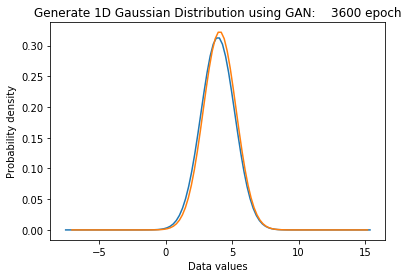

Epoch 3600: D (0.6940895318984985 real_err, 0.692939281463623 fake_err) G (0.6931747198104858 err); Real Dist ([4.074466526508331, 1.2608739313446606]),  Fake Dist ([4.061330105543137, 1.363707509645854]) 


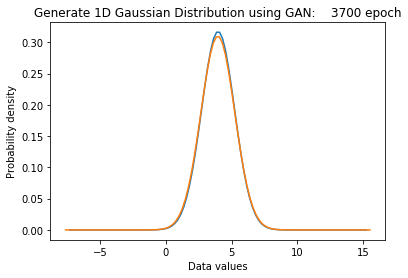

Epoch 3700: D (0.6934496760368347 real_err, 0.6929540634155273 fake_err) G (0.6934811472892761 err); Real Dist ([3.911323962330818, 1.1474675953410443]),  Fake Dist ([4.0804955294132235, 1.240818328101762]) 


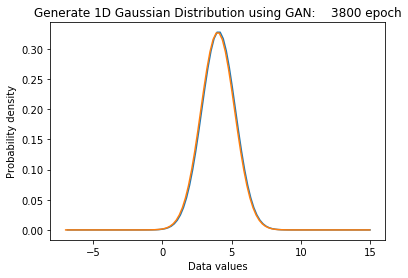

Epoch 3800: D (0.693342387676239 real_err, 0.6931717395782471 fake_err) G (0.693797767162323 err); Real Dist ([3.931743847489357, 1.1545031396992915]),  Fake Dist ([4.001724978685379, 1.1910886827594682]) 


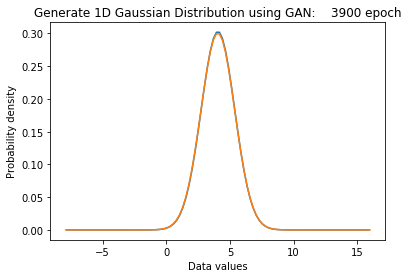

Epoch 3900: D (0.6927511096000671 real_err, 0.6932973861694336 fake_err) G (0.6930475234985352 err); Real Dist ([3.936021185480058, 1.3526764721681335]),  Fake Dist ([4.036196972131729, 1.2041787206876178]) 


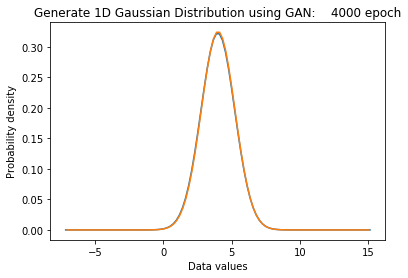

Epoch 4000: D (0.6977180242538452 real_err, 0.6929788589477539 fake_err) G (0.6931501626968384 err); Real Dist ([4.022418268710375, 1.2497364209041597]),  Fake Dist ([4.034000297307968, 1.2467334860036652]) 


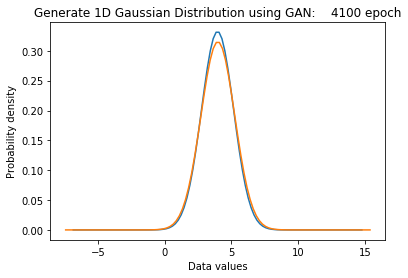

Epoch 4100: D (0.6934278011322021 real_err, 0.6935820579528809 fake_err) G (0.6926560401916504 err); Real Dist ([4.006943006753922, 1.206194961838583]),  Fake Dist ([4.025486803054809, 1.2769199856936015]) 


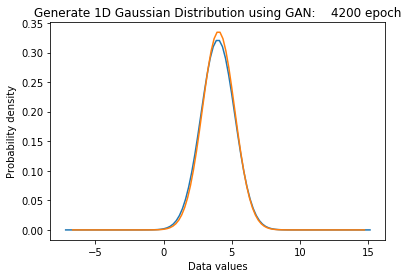

Epoch 4200: D (0.6928444504737854 real_err, 0.6935115456581116 fake_err) G (0.6926696300506592 err); Real Dist ([4.0542352713048455, 1.2542978600083543]),  Fake Dist ([4.039456976175308, 1.211384592337668]) 


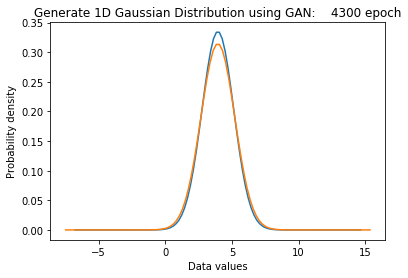

Epoch 4300: D (0.6928465962409973 real_err, 0.6933856010437012 fake_err) G (0.6932501792907715 err); Real Dist ([3.991323041498661, 1.256482441591787]),  Fake Dist ([3.972564257621765, 1.2531007154885527]) 


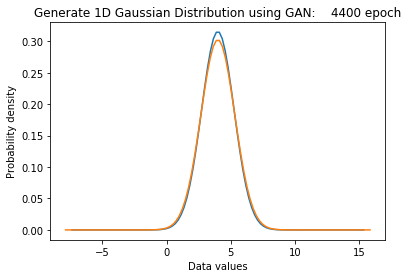

Epoch 4400: D (0.693263053894043 real_err, 0.6926509141921997 fake_err) G (0.6931182146072388 err); Real Dist ([3.930510514199734, 1.2493850900608137]),  Fake Dist ([4.015870424747467, 1.2835728835423377]) 


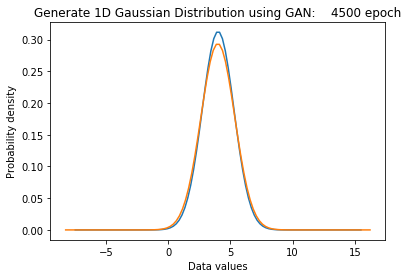

Epoch 4500: D (0.6927840113639832 real_err, 0.6933033466339111 fake_err) G (0.6947792172431946 err); Real Dist ([4.106169627398253, 1.1962090217871022]),  Fake Dist ([3.8937143654823303, 1.1569630489574223]) 


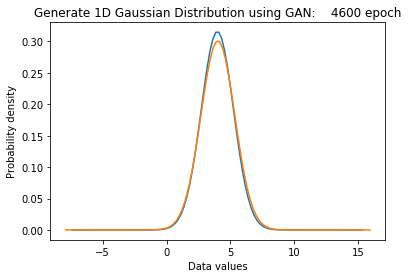

Epoch 4600: D (0.694549024105072 real_err, 0.6936948299407959 fake_err) G (0.6927632689476013 err); Real Dist ([4.035017550386488, 1.3021987579289067]),  Fake Dist ([3.94148646235466, 1.2935649234188402]) 


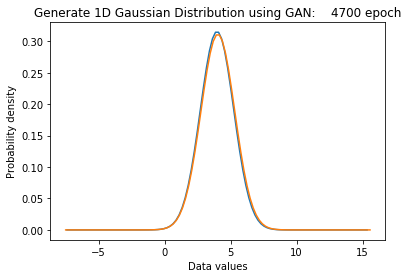

Epoch 4700: D (0.694504976272583 real_err, 0.6937502026557922 fake_err) G (0.6927888989448547 err); Real Dist ([4.03127714318037, 1.203305153751093]),  Fake Dist ([3.9807777347564697, 1.2557137152328297]) 


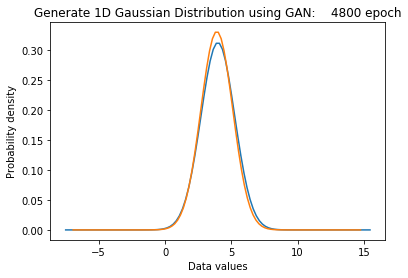

Epoch 4800: D (0.6942816376686096 real_err, 0.6926907300949097 fake_err) G (0.6928077340126038 err); Real Dist ([3.9752612989768386, 1.2294485430459858]),  Fake Dist ([3.98878262758255, 1.2707419312098909]) 


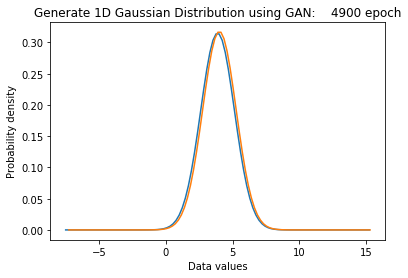

Epoch 4900: D (0.6933831572532654 real_err, 0.6933298110961914 fake_err) G (0.6935348510742188 err); Real Dist ([3.976176632873714, 1.268755686032596]),  Fake Dist ([4.044061214447021, 1.322125906361719]) 


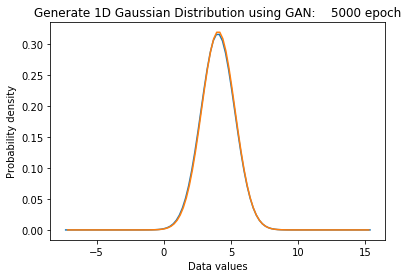

Plotting the generated distribution...
 Values: [1.2666122913360596, 4.318673133850098, 3.782942295074463, 4.320246696472168, 5.445282936096191, 4.768805503845215, 4.329126358032227, 3.475588321685791, 3.7902445793151855, 2.1608753204345703, 3.665281295776367, 4.091116905212402, 4.813825607299805, 6.227883338928223, 4.9859161376953125, 4.28813362121582, 4.381574630737305, 4.442360877990723, 6.9228410720825195, 3.7265708446502686, 3.389472484588623, 0.9343748092651367, 1.7787601947784424, 3.7220921516418457, 3.5673727989196777, 4.989114284515381, 4.07615327835083, 4.194677829742432, 2.6604866981506348, 4.646485328674316, 5.327877998352051, 2.934443950653076, 3.825359344482422, 6.8612260818481445, 3.854030132293701, 3.8996825218200684, 1.074027419090271, 3.9502527713775635, 1.7003268003463745, 6.178888320922852, 2.8760597705841064, 3.3749303817749023, 1.7252156734466553, 1.8257297277450562, 5.199916362762451, 5.454631328582764, 5.301321029663086, 1.7861406803131104, 3.887594699859619, 3.

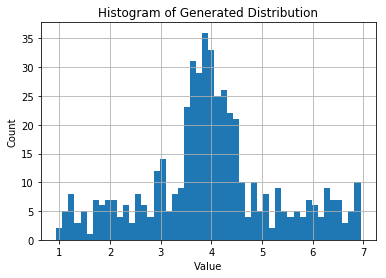

In [11]:
def train():
    # Model parameters
    g_input_size = 1   # Random noise dimension coming into generator, per output vector
    g_hidden_size = 5     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 500    # Minibatch size - cardinality of distributions
    d_hidden_size = 10    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 1e-3
    g_learning_rate = 1e-3
    sgd_momentum = 0.9

    num_epochs = 5000
    print_interval = 100
    d_steps = 20
    g_steps = 20

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    d_sampler = get_distribution_sampler(data_mean, data_stddev)
    gi_sampler = get_generator_input_sampler()
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function)
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function)
    criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size))
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones([1,1])))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1,1])))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1])))  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]

        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))
        
        if (epoch+1) % print_interval == 0:
            [mu_real, sigma_real] = stats(extract(d_real_data))
            [mu_fake, sigma_fake] = stats(extract(d_fake_data))

            x1 = np.linspace(mu_real-9*sigma_real,mu_real+9*sigma_real, 100)
            x2 = np.linspace(mu_fake-9*sigma_fake,mu_fake+9*sigma_fake, 100)
            plt.plot(x1, mlab.normpdf(x1, mu_real, sigma_real))
            plt.plot(x2, mlab.normpdf(x2, mu_fake, sigma_fake))
            plt.title('Generate 1D Gaussian Distribution using GAN: %7d epoch'%(epoch+1))
            plt.xlabel('Data values')
            plt.ylabel('Probability density')
            #plt.savefig('img/Generate 1D Gaussian Distribution using GAN: %7d epoch'%(epoch+1) + '.png', dpi=200)
            plt.show()

    if matplotlib_is_available:
        print("Plotting the generated distribution...")
        values = extract(g_fake_data)
        print(" Values: %s" % (str(values)))
        plt.hist(values, bins=50)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Histogram of Generated Distribution')
        plt.grid(True)
        plt.show()


train()